In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import os
import glob

In [2]:
base_path = "/mnt/c/Users/donna/Downloads/Thesis/correlation_results/exp1/all_samples/no_outliers"

In [3]:
region_map = {
    "covxvar": "Most Variable cfDNA",
    "peakvar": "Most Variable ATAC peaks"
}
default_region_type = "All Locations"


In [4]:
long_df = []

for file in os.listdir(base_path):
    if not file.endswith(".csv"):
        continue

    # Identify region type
    region_type = default_region_type
    for prefix, label in region_map.items():
        if file.startswith(prefix):
            region_type = label
            break

    # Define condition label (atac–cfDNA combo)
    condition = file.replace("covxvar_", "").replace("peakvar_", "").replace(".csv", "")
    condition = condition.replace("_", " ")

    # Load and melt
    df = pd.read_csv(os.path.join(base_path, file))
    df = df.melt(id_vars=[df.columns[0]], var_name="cfDNA_sample", value_name="Pearson Correlation Coefficient")
    df["Region Type"] = region_type
    df["Condition"] = condition
    long_df.append(df)
    
final_df = pd.concat(long_df, ignore_index=True)

label_map = {
    "brca atac brca cfDNA": "BRCA ATAC\nvs BRCA cfDNA",
    "brca atac coad cfDNA": "BRCA ATAC\nvs COAD cfDNA",
    "coad atac brca cfDNA": "COAD ATAC\nvs BRCA cfDNA",
    "coad atac coad cfDNA": "COAD ATAC\nvs COAD cfDNA"
}

final_df["Condition"] = final_df["Condition"].replace(label_map)

In [5]:
# Filter to only include the 'All Locations' subset
all_locations_df = final_df[final_df["Region Type"] == "All Locations"]

# Group by Condition and calculate the median
medians = all_locations_df.groupby("Condition")["Pearson Correlation Coefficient"].median()

# Print the median for each group
print("Median Pearson Correlation Coefficient (All Locations):\n")
for condition, median in medians.items():
    print(f"{condition}: {median:.4f}")


Median Pearson Correlation Coefficient (All Locations):

BRCA ATAC
vs BRCA cfDNA: -0.0739
BRCA ATAC
vs COAD cfDNA: -0.0708
COAD ATAC
vs BRCA cfDNA: -0.0803
COAD ATAC
vs COAD cfDNA: -0.0805


In [6]:
# Group by Region Type and then by Condition, and calculate the medians
grouped_medians = final_df.groupby(["Region Type", "Condition"])["Pearson Correlation Coefficient"].median()

# Print the median correlation for each Region Type and Condition
print("Median Pearson Correlation Coefficient by Region Type and Condition:\n")
for (region_type, condition), median in grouped_medians.items():
    print(f"{region_type:20} | {condition:30} | Median: {median:.4f}")


Median Pearson Correlation Coefficient by Region Type and Condition:

All Locations        | BRCA ATAC
vs BRCA cfDNA        | Median: -0.0739
All Locations        | BRCA ATAC
vs COAD cfDNA        | Median: -0.0708
All Locations        | COAD ATAC
vs BRCA cfDNA        | Median: -0.0803
All Locations        | COAD ATAC
vs COAD cfDNA        | Median: -0.0805
Most Variable ATAC peaks | BRCA ATAC
vs BRCA cfDNA        | Median: -0.0015
Most Variable ATAC peaks | BRCA ATAC
vs COAD cfDNA        | Median: 0.0140
Most Variable ATAC peaks | COAD ATAC
vs BRCA cfDNA        | Median: -0.0414
Most Variable ATAC peaks | COAD ATAC
vs COAD cfDNA        | Median: -0.0497
Most Variable cfDNA  | BRCA ATAC
vs BRCA cfDNA        | Median: 0.0260
Most Variable cfDNA  | BRCA ATAC
vs COAD cfDNA        | Median: 0.0243
Most Variable cfDNA  | COAD ATAC
vs BRCA cfDNA        | Median: -0.0229
Most Variable cfDNA  | COAD ATAC
vs COAD cfDNA        | Median: -0.0197


In [7]:
##MAAN WHITNEY U BETWEEN MATCHING CANCER AND MIS-MATCHING CANCER TYPES
from scipy.stats import mannwhitneyu

# Define groupings
matched_conditions = [
    "BRCA ATAC\nvs BRCA cfDNA",
    "COAD ATAC\nvs COAD cfDNA"
]
mismatched_conditions = [
    "BRCA ATAC\nvs COAD cfDNA",
    "COAD ATAC\nvs BRCA cfDNA"
]

# Get unique region subsets
region_types = final_df["Region Type"].unique()

# Store results
results = []

for region in region_types:
    subset_df = final_df[final_df["Region Type"] == region]
    
    matched = subset_df[subset_df["Condition"].isin(matched_conditions)]["Pearson Correlation Coefficient"]
    mismatched = subset_df[subset_df["Condition"].isin(mismatched_conditions)]["Pearson Correlation Coefficient"]
    
    stat, p_value = mannwhitneyu(matched, mismatched, alternative="two-sided")
    results.append((region, len(matched), len(mismatched), stat, p_value))
    delta = np.median(matched) - np.median(mismatched)
    direction = "↑" if delta > 0 else "↓" if delta < 0 else "="
    print(f"{region:20} | n_matched={len(matched):<4} n_mismatched={len(mismatched):<4} | U={stat:.2f} | p={p_value:.4e} | median = {delta:.4f} ({direction})")

All Locations        | n_matched=2838 n_mismatched=2874 | U=3760755.00 | p=3.5002e-07 | median = -0.0031 (↓)
Most Variable cfDNA  | n_matched=4614 n_mismatched=3786 | U=9649307.00 | p=1.2946e-16 | median = 0.0121 (↑)
Most Variable ATAC peaks | n_matched=4614 n_mismatched=3786 | U=8976669.00 | p=2.8406e-02 | median = 0.0062 (↑)


/tmp/ipykernel_36738/129533932.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels, fontsize=15, weight='bold', ha='center', linespacing=1.5)
/tmp/ipykernel_36738/129533932.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


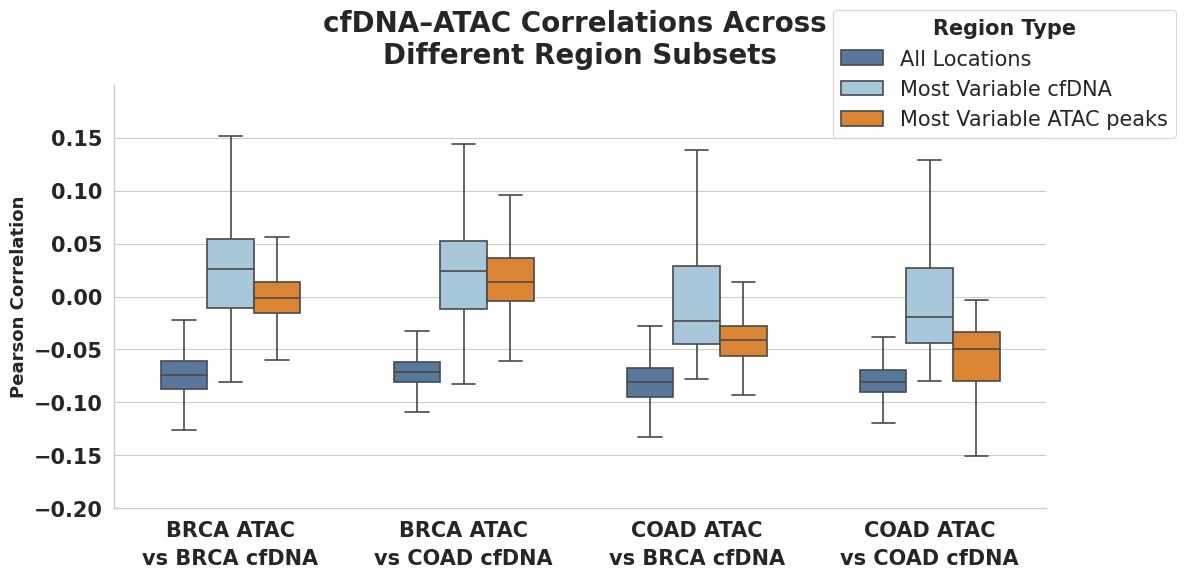

In [9]:
# --- Clean style ---
sns.set(style="whitegrid", context="paper", font_scale=1.2)

palette = ["#4C78A8", "#9EC9E2", "#F58518"]

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

sns.boxplot(  
    data=final_df,
    x="Condition",
    y="Pearson Correlation Coefficient",
    hue="Region Type",
    palette=palette,
    linewidth=1.2,
    fliersize=0,
    width=0.6,
    ax=ax  
)


# --- Y-axis limits and smaller tick labels ---
ax.set_ylim(-0.18, 0.2)
ax.set_yticks(np.arange(-0.2, 0.2, 0.05))
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# --- Labels and title ---
ax.set_xlabel("")
ax.set_ylabel("Pearson Correlation", fontsize=13, weight='bold')
ax.set_title("cfDNA–ATAC Correlations Across \nDifferent Region Subsets", fontsize=20, pad=15, weight='bold')

custom_labels = [
    "BRCA ATAC\nvs BRCA cfDNA",
    "BRCA ATAC\nvs COAD cfDNA",
    "COAD ATAC\nvs BRCA cfDNA",
    "COAD ATAC\nvs COAD cfDNA"
]

# Replace default tick labels in-place (keep original positions)
ax.set_xticklabels(custom_labels, fontsize=15, weight='bold', ha='center', linespacing=1.5)
# after you’ve drawn the plot …
for lbl in ax.get_yticklabels():
    lbl.set_fontweight('bold')





# --- Legend formatting ---
ax.legend(
    title="Region Type",
    loc="upper right",
    bbox_to_anchor=(1.15, 1.2), 
    frameon=True,
    fontsize=15,
    title_fontsize=15
)
ax.legend_.get_title().set_weight("bold")
# --- Remove top/right spines ---
sns.despine(trim=False)

# --- Final layout and export ---
plt.tight_layout()
plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/publication_boxplot_final.png", dpi=600)
plt.show()

In [ ]:
coad_atac  = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/atac_only/coad_atac_cor.csv', header=None).values[1:, 1:]
brca_atac  = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/atac_only/brca_atac_cor.csv', header=None).values[1:, 1:]

In [ ]:
coad_cfdna = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/cfDNA_only/coad_cfDNA_cor.csv', header=None).values[1:, 1:]
brca_cfdna  = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/cfDNA_only/brca_cfDNA_cor.csv', header=None).values[1:, 1:]

In [10]:

for df in [brca_atac_coad_cfDNA, brca_atac_brca_cfDNA, coad_atac_brca_cfDNA, coad_atac_coad_cfDNA]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

# Melt each one into long format
brca_atac_coad_cfDNA_m = brca_atac_coad_cfDNA.melt(var_name="cfDNA_sample", value_name="correlation")
brca_atac_coad_cfDNA_m["dataset"] = "brca atac coad cfDNA"

brca_atac_brca_cfDNA_m = brca_atac_brca_cfDNA.melt(var_name="cfDNA_sample", value_name="correlation")
brca_atac_brca_cfDNA_m["dataset"] = "brca atac brca cfDNA"

coad_atac_brca_cfDNA_m = coad_atac_brca_cfDNA .melt(var_name="cfDNA_sample", value_name="correlation")
coad_atac_brca_cfDNA_m["dataset"] = "coad atac brca cfDNA "

coad_atac_coad_cfDNA_m = coad_atac_coad_cfDNA .melt(var_name="cfDNA_sample", value_name="correlation")
coad_atac_coad_cfDNA_m["dataset"] = "coad atac coad cfDNA "

# Combine all
combined = pd.concat([brca_atac_brca_cfDNA_m, coad_atac_coad_cfDNA_m, brca_atac_coad_cfDNA_m, coad_atac_brca_cfDNA_m], ignore_index=True)

NameError: name 'brca_atac_coad_cfDNA' is not defined

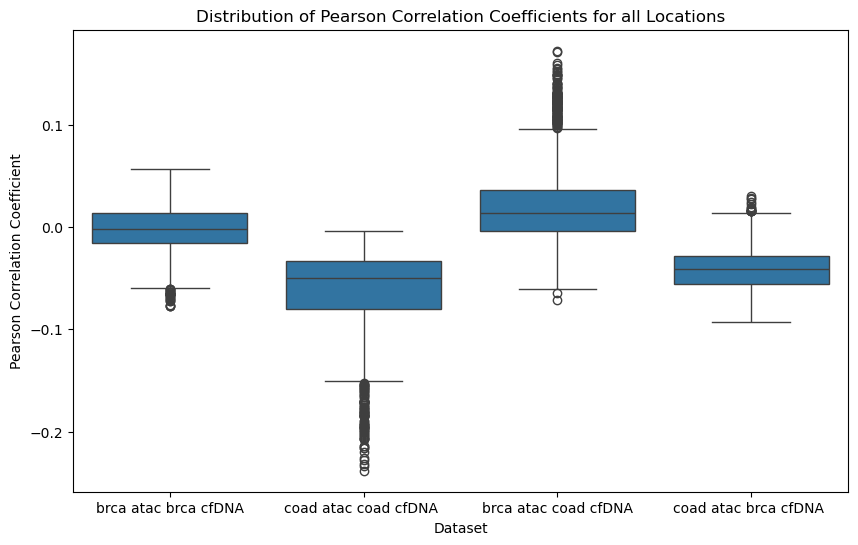

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="dataset", y="correlation", data=combined)
plt.title('Distribution of Pearson Correlation Coefficients for all Locations')
plt.xlabel('Dataset')
plt.ylabel('Pearson Correlation Coefficient')
plt.show()


In [24]:
# Calculate medians
medians = combined.groupby("dataset")["correlation"].median()

# Extract correlation values per group
group1 = combined[combined["dataset"] == "brca atac coad cfDNA"]["correlation"]
group2 = combined[combined["dataset"] == "brca atac brca cfDNA"]["correlation"]
group3 = combined[combined["dataset"] == "coad atac brca cfDNA "]["correlation"]

# Mann–Whitney U test (one-sided)
stat_1_vs_3, p_1_vs_3 = mannwhitneyu(group1, group3, alternative='less')
stat_2_vs_3, p_2_vs_3 = mannwhitneyu(group2, group3, alternative='less')

# Format results
results = pd.DataFrame({
    "Comparison": ["group1 < group3", "group2 < group3"],
    "U_statistic": [stat_1_vs_3, stat_2_vs_3],
    "p_value": [p_1_vs_3, p_2_vs_3],
    "significant (p < 0.05)": [p_1_vs_3 < 0.05, p_2_vs_3 < 0.05]
})

In [27]:
medians

dataset
brca atac brca cfDNA    -0.001543
brca atac coad cfDNA     0.014021
coad atac brca cfDNA    -0.041406
coad atac coad cfDNA    -0.049714
Name: correlation, dtype: float64

In [ ]:
# ONDERLINGE CORR PLOTS ATAC EN CFDNA COMBINED

In [24]:
coad_atac  = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/exp1/atac_only/coad_atac_cor.csv', header=None).values[1:, 1:]
brca_atac  = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/correlation_results/exp1/atac_only/brca_atac_cor.csv', header=None).values[1:, 1:]
coad_cfdna = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/correlation_results/exp1/cfDNA_only/coad_cfDNA_cor.csv", header=None).values[1:, 1:]
brca_cfdna = pd.read_csv("/mnt/c/Users/donna/Downloads/Thesis/correlation_results/exp1/cfDNA_only/brca_cfDNA_cor.csv", header=None).values[1:, 1:]

In [25]:
mask_coad = ~np.eye(coad_cfdna.shape[0],dtype=bool)
mask_brca = ~np.eye(brca_cfdna.shape[0],dtype=bool)
coad_cfdna = coad_cfdna[mask_coad]
brca_cfdna = brca_cfdna[mask_brca]

In [26]:
mask_coad2 = ~np.eye(coad_atac.shape[0],dtype=bool)
mask_brca2 = ~np.eye(brca_atac.shape[0],dtype=bool)
coad_atac = coad_atac[mask_coad2]
brca_atac = brca_atac[mask_brca2]

In [27]:
df = pd.DataFrame({
    "Correlation": np.concatenate([coad_cfdna, coad_atac,
                                   brca_cfdna, brca_atac]),
    "SampleType": (["cfDNA"]*len(coad_cfdna) + ["ATAC"]*len(coad_atac) +
                   ["cfDNA"]*len(brca_cfdna) + ["ATAC"]*len(brca_atac)),
    "CancerType": (["COAD"]* (len(coad_cfdna)+len(coad_atac)) +
                   ["BRCA"]*(len(brca_cfdna)+len(brca_atac)))
})

/tmp/ipykernel_3989/2039190223.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3989/2039190223.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


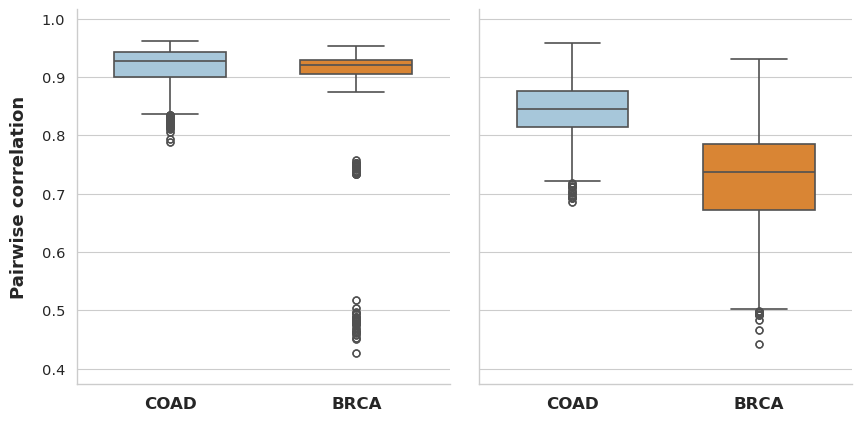

In [61]:
df = pd.DataFrame({
    "Correlation": np.concatenate([coad_cfdna, coad_atac, brca_cfdna, brca_atac]),
    "Cancer": (
        ["COAD"] * len(coad_cfdna) +
        ["COAD"] * len(coad_atac) +
        ["BRCA"] * len(brca_cfdna) +
        ["BRCA"] * len(brca_atac)
    ),
    "SampleType": (
        ["cfDNA"] * len(coad_cfdna) +
        ["ATAC"] * len(coad_atac) +
        ["cfDNA"] * len(brca_cfdna) +
        ["ATAC"] * len(brca_atac)
    )
})
df["Correlation"] = df["Correlation"].astype(float)

sns.set(style="whitegrid", context="paper", font_scale=1.2)
palette = {"COAD": "#9EC9E2", "BRCA": "#F58518"}

# compute y-limits once with 10% padding
ymin, ymax = df["Correlation"].min(), df["Correlation"].max()
pad = (ymax - ymin) * 0.10
ymin, ymax = ymin - pad, ymax + pad

fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"wspace": 0.08}
)
# give space above for the supertitle
fig.subplots_adjust(top=0.8, bottom=0.05)

for ax, samp in zip(axes, ["cfDNA", "ATAC"]):
    sub = df[df["SampleType"] == samp]
    sns.boxplot(
        data=sub,
        x="Cancer", y="Correlation",
        palette=palette,
        linewidth=1.2,
        fliersize=5,    # default fliersize to show only points outside whiskers
        width=0.6,
        order=["COAD", "BRCA"],
        ax=ax
    )


    ax.set_xlim(-0.5, 1.5)    # ensure full x-axis range
    ax.set_title("")          # remove panel titles
    ax.set_xlabel("")

    if samp == "cfDNA":
        ax.set_ylabel("Pairwise correlation", fontsize=13, weight="bold", labelpad=10)
    else:
        ax.set_ylabel("")

    ax.set_ylim(ymin, ymax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["COAD", "BRCA"], fontsize=12, weight="bold")

# fig.suptitle(
#     "Within-Group Correlations of cfDNA Coverage and ATAC-seq Profiles in COAD and BRCA Samples",
#     fontsize=15, weight="bold", y=0.94
# )
sns.despine(trim=False)
plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/within_group_correlations.png", dpi=300, bbox_inches="tight")
plt.show()


In [47]:
## ATAC ONLY PLOTS

In [ ]:
## ATAC ONLY PLOTS

In [3]:
coad_atac_eye = coad_atac[~np.eye(coad_atac.shape[0], dtype=bool)].astype(float)
brca_atac_eye = brca_atac[~np.eye(brca_atac.shape[0], dtype=bool)].astype(float)

/tmp/ipykernel_178665/381628562.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([coad_atac_eye, brca_atac_eye], labels=['COAD', 'BRCA'])


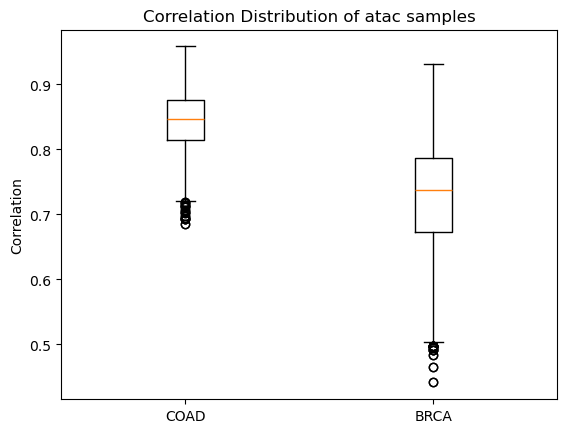

In [4]:
plt.boxplot([coad_atac_eye, brca_atac_eye], labels=['COAD', 'BRCA'])
plt.ylabel('Correlation')
plt.title('Correlation Distribution of atac samples')
plt.show()

In [7]:
## CFDNA ONLY PLOTS

In [8]:
coad_cfdna_eye = coad_cfdna[~np.eye(coad_cfdna.shape[0], dtype=bool)].astype(float)
brca_cfdna_eye = brca_cfdna[~np.eye(brca_cfdna.shape[0], dtype=bool)].astype(float)

In [11]:
mean_coad = np.nanmean(coad_cfdna_eye)
median_coad = np.nanmedian(coad_cfdna_eye)

mean_brca = np.nanmean(brca_cfdna_eye)
median_brca = np.nanmedian(brca_cfdna_eye)

In [12]:
print(f"COAD median = {median_coad}")
print(f"COAD mean = {mean_coad}")
print(f"BRCA median = {median_brca}")
print(f"BRCA mean = {mean_brca}")

COAD median = 0.9275494885938634
COAD mean = 0.9111705606322142
BRCA median = 0.9211089624552005
BRCA mean = 0.8766109340492624


/tmp/ipykernel_534687/1499529952.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([coad_cfdna_eye, brca_cfdna_eye], labels=['COAD', 'BRCA'])


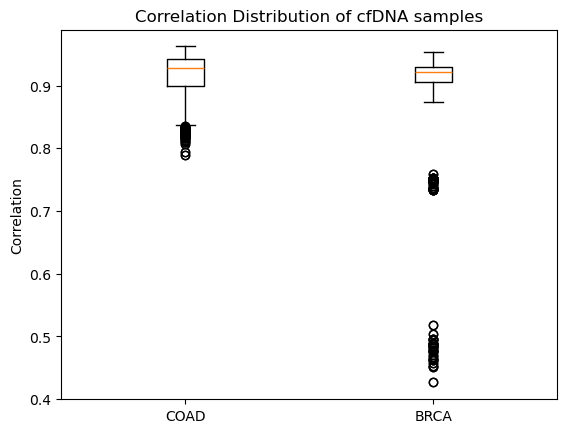

In [10]:
plt.boxplot([coad_cfdna_eye, brca_cfdna_eye], labels=['COAD', 'BRCA'])
plt.ylabel('Correlation')
plt.title('Correlation Distribution of cfDNA samples')
plt.show()

/tmp/ipykernel_3267/1499529952.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([coad_cfdna_eye, brca_cfdna_eye], labels=['COAD', 'BRCA'])


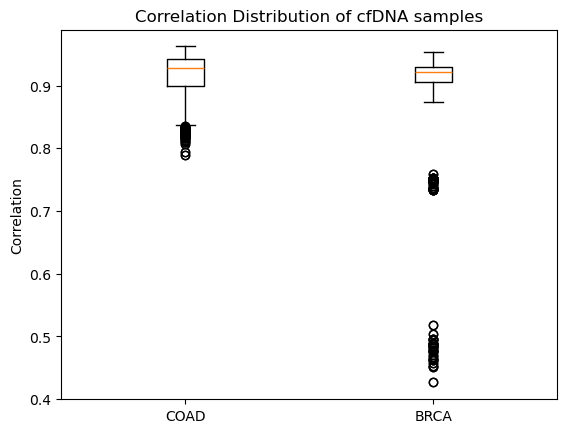

In [6]:
plt.boxplot([coad_cfdna_eye, brca_cfdna_eye], labels=['COAD', 'BRCA'])
plt.ylabel('Correlation')
plt.title('Correlation Distribution of cfDNA samples')
plt.show()